## Hello World

This will be my test bench for testing and relearning PyTorch

In [66]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

Next up, I'm downloading one of their multitude of datasets. Whose? Facebook's (who have collected a bunch from other sources into a single API call kinda thing hahahahahhaa)

In [67]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Below is to load the data into something workable for PyTorch

In [68]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


Now we will define our model

In [69]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to("cpu")
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


For training our model, we need some loss function and optimizer function for the model to 'learn'

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

This is our training function

In [71]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to("cpu"), y.to("cpu")

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

... and this is our testing function

In [72]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to("cpu"), y.to("cpu")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


... and finally this is to run the whole thing

In [73]:
epochs = 8
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305351  [    0/60000]
loss: 0.642021  [ 6400/60000]
loss: 0.394251  [12800/60000]
loss: 0.550530  [19200/60000]
loss: 0.520448  [25600/60000]
loss: 0.436681  [32000/60000]
loss: 0.388298  [38400/60000]
loss: 0.555964  [44800/60000]
loss: 0.483698  [51200/60000]
loss: 0.528856  [57600/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.441405 

Epoch 2
-------------------------------
loss: 0.281881  [    0/60000]
loss: 0.363394  [ 6400/60000]
loss: 0.282471  [12800/60000]
loss: 0.446895  [19200/60000]
loss: 0.373922  [25600/60000]
loss: 0.382292  [32000/60000]
loss: 0.327877  [38400/60000]
loss: 0.491119  [44800/60000]
loss: 0.401155  [51200/60000]
loss: 0.463512  [57600/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.403813 

Epoch 3
-------------------------------
loss: 0.256936  [    0/60000]
loss: 0.330773  [ 6400/60000]
loss: 0.224020  [12800/60000]
loss: 0.375926  [19200/60000]
loss: 0.343529  [25600/60000]
loss: 0.361090  [32000/600

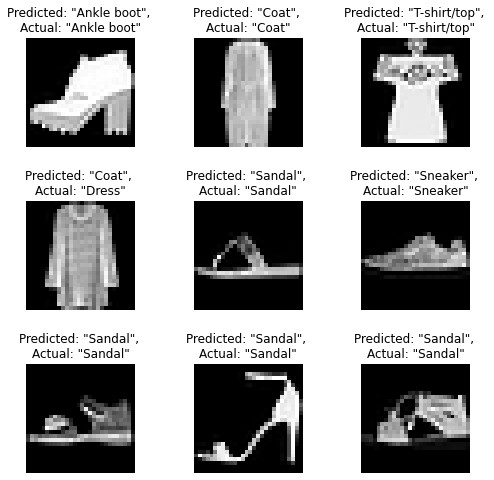

In [76]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
model.eval()
for i in range(1, cols * rows + 1):
    
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    x, y = test_data[sample_idx][0], test_data[sample_idx][1]
    with torch.no_grad():
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        
        figure.add_subplot(rows, cols, i)
        txt = f'Predicted: "{predicted}", \nActual: "{actual}"'
        plt.title(txt)
        plt.axis("off")
        plt.imshow(x.squeeze(), cmap="gray")
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


## Start of FYP testing on Fruit Recognition
Below will be the code for preparing the dataset for ML

In [27]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

REBUILD_DATA = True

class fruitification():
    
    """
    STEPS:
    1) Denote the file directory for Apples, Mangoes, Bananas, Grapes and Strawberries
    2) Label them with a dictionary. We'll use np.eye to handle the labelling into the training_data
    3) Training_data = []
    4) Count how many fruits for each Apples, Mangoes, etc...
    5) Shuffle the training_data
    6) Save it
    """
    
    # IMG_SIZE dictates the dimensions we wanna resize it into i.e. 50x50
    IMG_SIZE = 50
    
    # Directory of fruits
    AP = "fruits/apple"
    BN = "fruits/banana"
    GR = "fruits/grape"
    MG = "fruits/mango"
    ST = "fruits/strawberry"
    
    # Labels for fruits in numbers
    LABELS = {AP: 0, BN: 1, GR: 2, MG: 3, ST: 4}
    training_data = []
    counts = [0, 0, 0, 0, 0]
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            # Access the individual images inside each directory folder
            for f in tqdm(os.listdir(label)):
                try:
                    # Create the full path name here
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    # By default, opencv2 reads an image in BGR format
#                     img = cv2.imread(path) 
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    
                    # eye is identity matrix. self.LABELS[label] is just dictionary and key accessing
                    self.training_data.append([np.flip(np.array(img), axis=-1), np.eye(5)[self.LABELS[label]]])
                    # np.flip axis = -1 essentially flips BGR to RGB. Inverted flip kinda thing y'know
                    
                    # Count each fruit
                    self.counts[self.LABELS[label]] += 1
                        
                except:
                    pass
                
        # shuffling, cuz I heard it helps reduce the model from memorizing patterns
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(len(self.training_data))
        
        # printing the count for each fruits
        for i in self.LABELS:
            print(i[7:], ":", self.counts[self.LABELS[i]])

if REBUILD_DATA:
    fds = fruitification()
    print("Making...")
    fds.make_training_data()
    REBUILD_DATA = False

Making...
fruits/apple


100%|██████████| 1203/1203 [00:00<00:00, 1933.19it/s]


fruits/banana


100%|██████████| 1162/1162 [00:00<00:00, 2741.51it/s]


fruits/grape


100%|██████████| 1033/1033 [00:00<00:00, 2921.18it/s]


fruits/mango


100%|██████████| 1025/1025 [00:00<00:00, 3187.03it/s]


fruits/strawberry


100%|██████████| 1002/1002 [00:00<00:00, 3088.63it/s]


5425
apple : 1203
banana : 1162
grape : 1033
mango : 1025
strawberry : 1002


[0. 0. 1. 0. 0.]


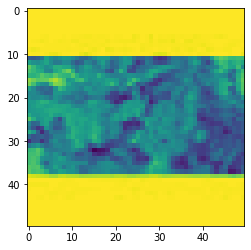

(5425, 2)


In [28]:
training_data = np.load("training_data.npy", allow_pickle = True)
                        
# training_data[...][0] ==> the actual image in array format
# training_data[...][1] ==> the label of image
idx = 1
# print(training_data[idx][0])
plt.imshow(training_data[idx][0])
print(training_data[idx][1])
plt.show()
print(training_data.shape)

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])


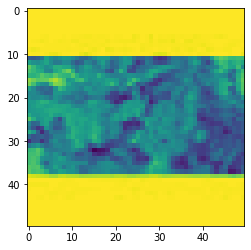

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


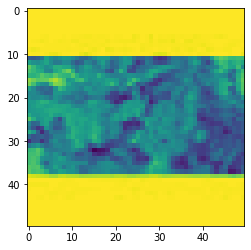

In [31]:
# # if .Tensor, no need the , 1 after -1
the_data = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)

print(the_data[1])
plt.imshow(the_data[1])
plt.show()

# # "Normalize" it into values between 0 and 1. Easier to train the model
the_data = the_data/255.0

print(the_data[1])
plt.imshow(the_data[1])
plt.show()

labellings = torch.Tensor([i[1] for i in training_data])

validation_perc = 0.1
validation_size = int(len(the_data) * validation_perc)

# # Basically 90% is for training
train_x = the_data[:-validation_size]
train_y = labellings[:-validation_size]

# # 10% for testing
test_x = the_data[-validation_size:]
test_y = labellings[-validation_size:]

In [32]:
print(the_data.shape)
print(labellings.shape)

torch.Size([5425, 50, 50])
torch.Size([5425, 5])


In [33]:
import torch.nn as nn
import torch.nn.functional as F


class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # image channel == 1, output channel == 6, kernel filter == 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 9 * 9, 120) # 16 cuz from conv2, 5 and 5 cuz of our kernel filters above
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         return torch.nn.functional.softmax(x, dim=1)
        return x


model = NeuralNet()

In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(train_x.shape)
print(train_y.shape)

torch.Size([4883, 50, 50])
torch.Size([4883, 5])


In [35]:
BATCH_SIZE = 100
EPOCHS = 10

# Training time
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
        batch_x = train_x[i: i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i+BATCH_SIZE]
        
        model.zero_grad()
        
#         print(batch_x.shape)
        outputs = model(batch_x)
#         print(outputs.shape)
#         print(batch_y.shape)
        loss = loss_fn(outputs, torch.max(batch_y, 1)[1])
        loss.backward()
        optimizer.step()
    
    print(f"Epoch: {epoch+1}. Loss: {loss}")

  0%|          | 0/49 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  2%|▏         | 1/49 [00:00<00:12,  3.71it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 12%|█▏        | 6/49 [00:00<00:03, 13.81it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 22%|██▏       | 11/49 [00:00<00:02, 17.58it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 35%|███▍      | 17/49 [00:01<00:01, 18.90it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 41%|████      | 20/49 [00:01<00:01, 19.39it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 53%|█████▎    | 26/49 [00:01<00:01, 19.45it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 59%|█████▉    | 29/49 [00:01<00:01, 19.82it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 71%|███████▏  | 35/49 [00:01<00:00, 19.80it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 76%|███████▌  | 37/49 [00:02<00:00, 19.70it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 90%|████████▉ | 44/49 [00:02<00:00, 19.77it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 96%|█████████▌| 47/49 [00:02<00:00, 20.07it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])


100%|██████████| 49/49 [00:02<00:00, 18.38it/s]


Epoch: 1. Loss: 1.545719027519226


  4%|▍         | 2/49 [00:00<00:02, 19.18it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 12%|█▏        | 6/49 [00:00<00:02, 19.53it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 24%|██▍       | 12/49 [00:00<00:01, 20.13it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 37%|███▋      | 18/49 [00:00<00:01, 20.19it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 43%|████▎     | 21/49 [00:01<00:01, 20.29it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 55%|█████▌    | 27/49 [00:01<00:01, 20.57it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 67%|██████▋   | 33/49 [00:01<00:00, 20.66it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 73%|███████▎  | 36/49 [00:01<00:00, 20.70it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 86%|████████▌ | 42/49 [00:02<00:00, 20.67it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 98%|█████████▊| 48/49 [00:02<00:00, 20.66it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])


100%|██████████| 49/49 [00:02<00:00, 20.48it/s]


Epoch: 2. Loss: 1.5350005626678467


  4%|▍         | 2/49 [00:00<00:02, 19.83it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 16%|█▋        | 8/49 [00:00<00:02, 20.15it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 22%|██▏       | 11/49 [00:00<00:01, 20.08it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 29%|██▊       | 14/49 [00:00<00:01, 20.25it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 35%|███▍      | 17/49 [00:00<00:01, 20.17it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])

 41%|████      | 20/49 [00:00<00:01, 19.91it/s]


torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 55%|█████▌    | 27/49 [00:01<00:01, 19.80it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 59%|█████▉    | 29/49 [00:01<00:01, 19.84it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 73%|███████▎  | 36/49 [00:01<00:00, 19.28it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 82%|████████▏ | 40/49 [00:02<00:00, 19.26it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 88%|████████▊ | 43/49 [00:02<00:00, 19.58it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


100%|██████████| 49/49 [00:02<00:00, 19.85it/s]


torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])
Epoch: 3. Loss: 1.4307100772857666


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([100, 5])
torch.Size([100, 5])


  4%|▍         | 2/49 [00:00<00:02, 19.35it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 10%|█         | 5/49 [00:00<00:02, 20.09it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 16%|█▋        | 8/49 [00:00<00:02, 20.31it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 29%|██▊       | 14/49 [00:00<00:01, 20.49it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 35%|███▍      | 17/49 [00:00<00:01, 20.51it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 41%|████      | 20/49 [00:00<00:01, 20.50it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 47%|████▋     | 23/49 [00:01<00:01, 20.56it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 59%|█████▉    | 29/49 [00:01<00:00, 20.64it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 65%|██████▌   | 32/49 [00:01<00:00, 20.54it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 71%|███████▏  | 35/49 [00:01<00:00, 20.45it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 78%|███████▊  | 38/49 [00:01<00:00, 20.08it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 88%|████████▊ | 43/49 [00:02<00:00, 19.91it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 92%|█████████▏| 45/49 [00:02<00:00, 19.86it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 98%|█████████▊| 48/49 [00:02<00:00, 19.94it/s]

torch.Size([83, 5])
torch.Size([83, 5])


100%|██████████| 49/49 [00:02<00:00, 20.29it/s]


Epoch: 4. Loss: 1.3459868431091309


  4%|▍         | 2/49 [00:00<00:02, 19.29it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 10%|█         | 5/49 [00:00<00:02, 19.82it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 16%|█▋        | 8/49 [00:00<00:02, 20.02it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 22%|██▏       | 11/49 [00:00<00:01, 20.07it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 35%|███▍      | 17/49 [00:00<00:01, 20.01it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 41%|████      | 20/49 [00:00<00:01, 20.14it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 47%|████▋     | 23/49 [00:01<00:01, 20.21it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 53%|█████▎    | 26/49 [00:01<00:01, 20.39it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 65%|██████▌   | 32/49 [00:01<00:00, 20.36it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 71%|███████▏  | 35/49 [00:01<00:00, 20.33it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 78%|███████▊  | 38/49 [00:01<00:00, 20.39it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 84%|████████▎ | 41/49 [00:02<00:00, 20.08it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 90%|████████▉ | 44/49 [00:02<00:00, 20.09it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 96%|█████████▌| 47/49 [00:02<00:00, 19.99it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])


100%|██████████| 49/49 [00:02<00:00, 20.19it/s]


Epoch: 5. Loss: 1.2846819162368774


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


  6%|▌         | 3/49 [00:00<00:02, 20.31it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 12%|█▏        | 6/49 [00:00<00:02, 20.41it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 18%|█▊        | 9/49 [00:00<00:01, 20.21it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 24%|██▍       | 12/49 [00:00<00:01, 20.07it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 31%|███       | 15/49 [00:00<00:01, 19.79it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 35%|███▍      | 17/49 [00:00<00:01, 19.73it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 39%|███▉      | 19/49 [00:00<00:01, 19.75it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 43%|████▎     | 21/49 [00:01<00:01, 19.66it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 47%|████▋     | 23/49 [00:01<00:01, 19.74it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 55%|█████▌    | 27/49 [00:01<00:01, 19.47it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 59%|█████▉    | 29/49 [00:01<00:01, 19.35it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 65%|██████▌   | 32/49 [00:01<00:00, 19.58it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 69%|██████▉   | 34/49 [00:01<00:00, 19.66it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 76%|███████▌  | 37/49 [00:01<00:00, 19.97it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 82%|████████▏ | 40/49 [00:02<00:00, 20.10it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 88%|████████▊ | 43/49 [00:02<00:00, 20.14it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 94%|█████████▍| 46/49 [00:02<00:00, 19.89it/s]

torch.Size([100, 5])
torch.Size([100, 5])


100%|██████████| 49/49 [00:02<00:00, 19.81it/s]


torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])
Epoch: 6. Loss: 1.247765302658081


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([100, 5])
torch.Size([100, 5])


  4%|▍         | 2/49 [00:00<00:02, 18.77it/s]

torch.Size([100, 5])
torch.Size([100, 5])


  8%|▊         | 4/49 [00:00<00:02, 19.44it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 16%|█▋        | 8/49 [00:00<00:02, 19.65it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 20%|██        | 10/49 [00:00<00:01, 19.60it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 24%|██▍       | 12/49 [00:00<00:01, 19.65it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 29%|██▊       | 14/49 [00:00<00:01, 19.50it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 33%|███▎      | 16/49 [00:00<00:01, 19.37it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 37%|███▋      | 18/49 [00:00<00:01, 19.47it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 41%|████      | 20/49 [00:01<00:01, 19.56it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 45%|████▍     | 22/49 [00:01<00:01, 19.61it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 49%|████▉     | 24/49 [00:01<00:01, 19.56it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 53%|█████▎    | 26/49 [00:01<00:01, 19.65it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 57%|█████▋    | 28/49 [00:01<00:01, 19.69it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 61%|██████    | 30/49 [00:01<00:00, 19.71it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 65%|██████▌   | 32/49 [00:01<00:00, 19.73it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 69%|██████▉   | 34/49 [00:01<00:00, 19.60it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 73%|███████▎  | 36/49 [00:01<00:00, 19.63it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 78%|███████▊  | 38/49 [00:01<00:00, 19.69it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 82%|████████▏ | 40/49 [00:02<00:00, 19.58it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 86%|████████▌ | 42/49 [00:02<00:00, 19.31it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 90%|████████▉ | 44/49 [00:02<00:00, 19.43it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 94%|█████████▍| 46/49 [00:02<00:00, 19.56it/s]

torch.Size([100, 5])
torch.Size([100, 5])


100%|██████████| 49/49 [00:02<00:00, 19.60it/s]


torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])
Epoch: 7. Loss: 1.2186309099197388


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([100, 5])
torch.Size([100, 5])


  8%|▊         | 4/49 [00:00<00:02, 19.43it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 16%|█▋        | 8/49 [00:00<00:02, 19.60it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 20%|██        | 10/49 [00:00<00:01, 19.65it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 24%|██▍       | 12/49 [00:00<00:01, 19.66it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 29%|██▊       | 14/49 [00:00<00:01, 19.62it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 33%|███▎      | 16/49 [00:00<00:01, 19.68it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 37%|███▋      | 18/49 [00:00<00:01, 19.69it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 41%|████      | 20/49 [00:01<00:01, 19.77it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 45%|████▍     | 22/49 [00:01<00:01, 19.80it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 49%|████▉     | 24/49 [00:01<00:01, 19.79it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 55%|█████▌    | 27/49 [00:01<00:01, 19.93it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 63%|██████▎   | 31/49 [00:01<00:00, 19.92it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 67%|██████▋   | 33/49 [00:01<00:00, 19.79it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 71%|███████▏  | 35/49 [00:01<00:00, 19.62it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 82%|████████▏ | 40/49 [00:02<00:00, 19.84it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 86%|████████▌ | 42/49 [00:02<00:00, 19.80it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 90%|████████▉ | 44/49 [00:02<00:00, 19.84it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 94%|█████████▍| 46/49 [00:02<00:00, 19.87it/s]

torch.Size([100, 5])
torch.Size([100, 5])


100%|██████████| 49/49 [00:02<00:00, 19.78it/s]


torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])
Epoch: 8. Loss: 1.1860767602920532


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([100, 5])
torch.Size([100, 5])


  8%|▊         | 4/49 [00:00<00:02, 18.79it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 16%|█▋        | 8/49 [00:00<00:02, 19.15it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 22%|██▏       | 11/49 [00:00<00:01, 19.58it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 33%|███▎      | 16/49 [00:00<00:01, 19.93it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 43%|████▎     | 21/49 [00:01<00:01, 19.86it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 53%|█████▎    | 26/49 [00:01<00:01, 19.95it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 63%|██████▎   | 31/49 [00:01<00:00, 20.01it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 73%|███████▎  | 36/49 [00:01<00:00, 19.99it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 86%|████████▌ | 42/49 [00:02<00:00, 19.82it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 94%|█████████▍| 46/49 [00:02<00:00, 19.74it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


100%|██████████| 49/49 [00:02<00:00, 19.81it/s]


torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])
Epoch: 9. Loss: 1.1620291471481323


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


  8%|▊         | 4/49 [00:00<00:02, 19.60it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 12%|█▏        | 6/49 [00:00<00:02, 19.76it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 16%|█▋        | 8/49 [00:00<00:02, 19.70it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 20%|██        | 10/49 [00:00<00:01, 19.71it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 24%|██▍       | 12/49 [00:00<00:01, 19.47it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 29%|██▊       | 14/49 [00:00<00:01, 19.41it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 33%|███▎      | 16/49 [00:00<00:01, 19.37it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 37%|███▋      | 18/49 [00:00<00:01, 19.56it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 41%|████      | 20/49 [00:01<00:01, 19.55it/s]

torch.Size([100, 5])
torch.Size([100, 5])


 45%|████▍     | 22/49 [00:01<00:01, 19.62it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 57%|█████▋    | 28/49 [00:01<00:01, 19.94it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 65%|██████▌   | 32/49 [00:01<00:00, 19.81it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 76%|███████▌  | 37/49 [00:01<00:00, 20.02it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 88%|████████▊ | 43/49 [00:02<00:00, 20.14it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])


 94%|█████████▍| 46/49 [00:02<00:00, 20.19it/s]

torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([100, 5])
torch.Size([83, 5])
torch.Size([83, 5])


100%|██████████| 49/49 [00:02<00:00, 19.94it/s]

Epoch: 10. Loss: 1.1371674537658691


In [36]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = model(test_x[i].view(-1, 1, 50, 50)) # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3)*100)

100%|██████████| 542/542 [00:00<00:00, 1558.51it/s]

Accuracy:  53.1


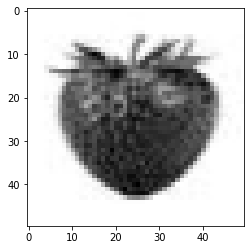

Predicted:  Strawberry
Actual:  Strawberry


In [47]:
index = 0
actual_img = test_x[index]

plt.imshow(actual_img, cmap="gray")
plt.show()

# torch.argmax returns the indices with the highest probability
actual_label = torch.argmax(test_y[index])
network_output = model(test_x[index].view(-1, 1, 50, 50))
predicted_label = torch.argmax(network_output)
# print(network_output)
# print(predicted_label)

l = ["Apple", "Banana", "Grape", "Mango", "Strawberry"]
print("Predicted: ", l[predicted_label.item()])
print("Actual: ", l[actual_label.item()])